## Import Packages

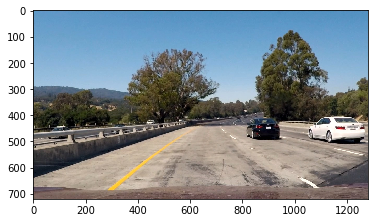

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import os
%matplotlib inline
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import math
import queue

# Validate we can show an image
plt.imshow(mpimg.imread(os.path.join("test_images","test1.jpg"))) 

## Original Lane Detection Helpers

The cell below contains an edited down version of my original lane finding pipeline from the first project.  This is needed to find lanes on a simple image with straight lane lines to use for calibrating my perspective transform later. 

You can find the original here:  https://github.com/dylanbrandtner/CarND-LaneLines-P1-Dylan 

In [2]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def clean_lines(lines, region_of_interest_verticies):  
    """Cleans up the list of lines and calulates 
    a single extrapolated left and right lane line   
    """
    #Remove anything with a slope to close to 0 (horizontal lines)        
    pruned_lines = []
    for line in lines: 
        for x1,y1,x2,y2 in line:
            slope = ((y2-y1)/(x2-x1))
            if (slope > 0.4 or slope < -0.4):
                pruned_lines.append(line)  
                    
    lines = np.array(pruned_lines)    
    
    # Separate by slope into left and right
    left_lines = []
    right_lines = []
    for line in lines: 
        for x1,y1,x2,y2 in line:
            slope = ((y2-y1)/(x2-x1)) 
            if slope < 0:
                left_lines.append([x1,y1,x2,y2])
            else:
                right_lines.append([x1,y1,x2,y2])
      
    
    #Calc extrapolated left line.  Pull y values from region of interest
    extraoplated_x_left = extrapolate_line(np.average(np.array(left_lines), axis=0),
                                      region_of_interest_verticies[0][1],
                                      region_of_interest_verticies[1][1])

    left_line = [(extraoplated_x_left[0], region_of_interest_verticies[0][1]), 
                       (extraoplated_x_left[1], region_of_interest_verticies[1][1])]
    
    #Calc extrapolated right line.  Pull y values from region of interest
    extraoplated_x_right = extrapolate_line(np.average(np.array(right_lines), axis=0),
                                      region_of_interest_verticies[2][1],
                                      region_of_interest_verticies[3][1])
    
    right_line = [(extraoplated_x_right[0], region_of_interest_verticies[2][1]), 
                       (extraoplated_x_right[1], region_of_interest_verticies[3][1])]
    
    return [left_line,right_line]


def extrapolate_line(line, y_boundary_1, y_boundary_2):
    """Extrapolates a input line to the given y boundaries"""
    # Calculate slope
    try:
        slope = ((line[3]-line[1])/(line[2]-line[0])) 
    except IndexError:
        # For some reason, the "Challege" video causes HoughLinesP to produce some "empty" lines...
        return [-1,-1]        
    
    # Calculate x1 and x2 using modified slope forumla x1 = x2 - (y2 -y1)/slope 
    x1 = int(line[0] - (line[1] - y_boundary_1)/slope)
    x2 = int(line[2] - (line[3] - y_boundary_2)/slope)
    
    return [x1,x2]


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, region_of_interest_verticies):
    """Returns an image with hough lines drawn."""
    
    #Get all the lines from the input image
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    #Create a base image
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)    
            
    # Clean the lines and draw them on the image
    cleaned_lines = clean_lines(lines, region_of_interest_verticies)
    cv2.line(line_img, cleaned_lines[0][0], cleaned_lines[0][1], [255, 0, 0], 5)
    cv2.line(line_img, cleaned_lines[1][0], cleaned_lines[1][1], [255, 0, 0], 5)
    
    # Draw the region of interest
    cv2.line(line_img,tuple(region_of_interest_verticies[0]),tuple(region_of_interest_verticies[1]), [0,255,0], 7)
    cv2.line(line_img,tuple(region_of_interest_verticies[1]),tuple(region_of_interest_verticies[2]), [0,255,0], 7)
    cv2.line(line_img,tuple(region_of_interest_verticies[2]),tuple(region_of_interest_verticies[3]), [0,255,0], 7)
    cv2.line(line_img,tuple(region_of_interest_verticies[3]),tuple(region_of_interest_verticies[0]), [0,255,0], 7)
    
    return cleaned_lines, line_img

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)


def lane_finding_pipeline(img, region_mask):
    """Full original lane finding pipeline.  
    Takes in an image and region mask, 
    and returns the two lane lines and a 
    marked image with the lines and region mask overliad"""
    
    #Use Canny edge detection on graysclaed image
    guassian_kernel_size = 5
    low_threshold = 50
    high_threshold = 150
    edges = canny(gaussian_blur(grayscale(img),guassian_kernel_size),low_threshold,high_threshold)
    
    # Mask area of interest (Use image size to calculate this to account for image/video sizes)
    masked_image = region_of_interest(edges,region_mask)
    
    # Apply Hough transform and draw wighted lines  
    rho = 2
    theta = np.pi/180
    threshold = 15
    min_line_len = 40
    max_line_gap = 2
    lines, line_img = hough_lines(masked_image,rho, theta, threshold, min_line_len, max_line_gap,region_mask[0])
    
    #Overlay the line image with the original
    line_img = weighted_img(line_img,img)
    return lines, line_img


## Camera Calibration

Here I setup a class to contain all the necessary calibration data, including distortion correction and perspective transformation data.

In [3]:
class CameraCalibration():
    """A class that contains the calibration data gathered from input calibration images

    Attributes:
        ym_per_pix (int): Meters per pixel in the y direction
        xm_per_pix (int): Meters per pixel in the x direction
        chessboardImagesPath (str): The path to the calibration chessboard images
        perspectiveTransformCalibrationFilePath (str): Path to the image used for perspective transform calculation
        nx (int): number of cols in the calibration chessboards
        ny (int): number of rows the calibration chessboards
        mtx(array): camera matrix
        dist(array): distortion coefficients
        M (array): transformation matrix
        Minv (array): inverse transformation matrix
    """
    def __init__(self, chessboardImagesPathIn, nxIn, nyIn, perspectiveTransformCalibrationFilePathIn):        
        
        # Constants
        self.ym_per_pix = 30/720 # meters per pixel in y dimension, taken from course materials
        self.xm_per_pix = 3.7/700 # meters per pixel in x dimension, taken from course materials
        
        # Input params
        self.chessboardImagesPath = chessboardImagesPathIn
        self.perspectiveTransformCalibrationFilePath = perspectiveTransformCalibrationFilePathIn
        self.nx = nxIn
        self.ny = nyIn
        
        # Stored calibration data
        self.mtx = None
        self.dist = None
        self.M = None
        self.Minv = None
        
        # Initialize Cal data on creation
        self.process_calibration_data()
    
    def process_calibration_data(self):
        """Executes both calibration calculations"""
        self.calc_distortion()
        self.calc_perspective()
    
    def calc_distortion(self):
        """Calculates the distortion coefficients using the input calibration images"""
        
        # Obj points and img points for calibration
        objpoints = []
        imgpoints = [] 
        objp = np.zeros((self.nx*self.ny,3), np.float32)
        objp[:,:2] = np.mgrid[0:self.nx,0:self.ny].T.reshape(-1,2)
        
        # Read input chessboard images
        images = glob.glob(os.path.join(self.chessboardImagesPath,"*.jpg"))
        for fname in images:
            img = mpimg.imread(fname)
            
            #Convert to greyscale
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            
            #Find corners
            ret, corners = cv2.findChessboardCorners(gray, (self.nx,self.ny), None)
            if ret:
                imgpoints.append(corners)
                objpoints.append(objp)
                
        # Calculate distortion coefficients
        ret, self.mtx, self.dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, 
                                                                     imgpoints, gray.shape[::-1], 
                                                                     None, None)
   
    def calc_perspective(self, plot_lane_image=False):
        """Calculates the perpsective trainform matrix.
        
        First executes the original lane finding pipeline on a simple straight
        lane image, and then maps that to vertically oriented lines in an overhead perspective.        
        """
        img = mpimg.imread(self.perspectiveTransformCalibrationFilePath)
        
        ### Use original line finding to find the lanes on the perspective calibration image 
        imshape = img.shape
        left_cutoff = 100
        right_cutoff = 50
        bottom_cutoff = 50
        top_cutoff = imshape[0]/2+125
        endpoint_lane_width = 350
        region_mask = np.array([[(left_cutoff,imshape[0]-bottom_cutoff),
                        (imshape[1]/2 - endpoint_lane_width/2, top_cutoff), 
                        (imshape[1]/2 + endpoint_lane_width/2, top_cutoff), 
                        (imshape[1]-right_cutoff,imshape[0]-bottom_cutoff)]], 
                        dtype=np.int32)        
        lines, lane_image = lane_finding_pipeline(img,region_mask)
        
        
        # Show the marked image if requested
        if plot_lane_image:
            plt.imshow(lane_image)
        
        # Set the source and destination points to transform the image to overhead
        src = np.float32([lines[0][0],
                          lines[0][1],
                          lines[1][0],
                          lines[1][1]])
        dst = np.float32([[lines[0][0][0]-left_cutoff,imshape[0]],
                          [lines[0][0][0]-left_cutoff,0],
                          [lines[1][1][0]+right_cutoff,0],
                          [lines[1][1][0]+right_cutoff,imshape[0]]])
        
        print(src)
        print(dst)
        
        # Calculate perspective transform matrices
        self.M = cv2.getPerspectiveTransform(src, dst)
        self.Minv = cv2.getPerspectiveTransform(dst, src)

    def undistort_image(self, InputImage):
        """Undistort image using internal distortion coefficients"""
        return cv2.undistort(InputImage, self.mtx, self.dist, None, self.mtx)
        
    def warp_to_overhead_perspective(self, InputImage):
        """Warp to overhead using transform matrix"""
        return cv2.warpPerspective(InputImage, self.M, 
                                   (InputImage.shape[1],InputImage.shape[0]), 
                                   flags=cv2.INTER_LINEAR)
        
    def warp_to_original_perspective(self, InputImage):
        """Warp to original using inverse transform matrix"""
        return cv2.warpPerspective(InputImage, self.Minv, 
                                   (InputImage.shape[1],InputImage.shape[0]), 
                                   flags=cv2.INTER_LINEAR)


In [4]:
#Gather calibration data
cameraCal = CameraCalibration("camera_cal",9,6, os.path.join("test_images","straight_lines2.jpg"))

[[  287.   670.]
 [  543.   485.]
 [  743.   485.]
 [ 1032.   670.]]
[[  187.   720.]
 [  187.     0.]
 [ 1082.     0.]
 [ 1082.   720.]]


In [5]:
# Test cal data on simple straight line image 
straight_lines = mpimg.imread(os.path.join("test_images","straight_lines2.jpg"))
# First undistort the image
undist = cameraCal.undistort_image(straight_lines)

fig = plt.figure(figsize=(20,10))
plt.axis('off')
ax = fig.add_subplot(1,2,1)
ax.imshow(straight_lines)
ax.set_title("Original")
ax = fig.add_subplot(1,2,2)
ax.imshow(undist)
ax.set_title("Undistorted")

In [6]:
# Apply perspective transform 
transformed_image = cameraCal.warp_to_overhead_perspective(undist)
plt.imshow(transformed_image)

## Camera Helper Class

Here I setup a class to contain each camera image and apply the various imaging operations.

In [7]:
class CameraImage():
    """A class that contains the characteristics of each camera image being used for lane detection.

    Attributes:
        img (image): The current image
        orginalImage (image): The original image passed into this class
        cal (CameraCalibration):  Camera calibration data
        improved_thresh(boolean): added later to improve the threshold
        distorted(boolean): whether or not the image is distorted
        thresholds_applied(boolean): whether or not the imaging thresholds have been applied
        transformed(boolean): whether or not a perspective transform has been applied        
    """
    def __init__(self, imageIn, cameraCal, improvedThreshIn=False): 
        
        # The current image
        self.img = imageIn
        
        # Input information
        self.originalImage = imageIn
        self.cal = cameraCal
        self.improved_thresh = improvedThreshIn
        
        # State information
        self.distorted = True
        self.thresholds_applied = False
        self.transformed = False 
        
                           
    def abs_sobel_thresh(self, img, orient='x', sobel_kernel=3, thresh=(0, 255)): 
        """Applies gradient Sobel threshold in the specified direction"""
        # Apply x or y gradient with the OpenCV Sobel() function
        # and take the absolute value
        if orient == 'x':
            abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0))
        if orient == 'y':
            abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1))
        # Rescale back to 8 bit integer
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
        # Create a copy and apply the threshold
        binary_output = np.zeros_like(scaled_sobel)
        # Use inclusive thresholds
        binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
        # Return the result
        return binary_output

    def mag_thresh(self, img, sobel_kernel=3, thresh=(0, 255)):  
        """Applies a gradient magnitude threshold"""
        # Take both Sobel x and y gradients
        sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        # Calculate the gradient magnitude
        gradmag = np.sqrt(sobelx**2 + sobely**2)
        # Rescale to 8 bit
        scale_factor = np.max(gradmag)/255 
        gradmag = (gradmag/scale_factor).astype(np.uint8) 
        # Create a binary image of ones where threshold is met, zeros otherwise
        binary_output = np.zeros_like(gradmag)
        binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

        # Return the binary image
        return binary_output

    def dir_threshold(self, img, sobel_kernel=3, thresh=(0, np.pi/2)):  
        """Applies a directional gradient theshold"""
        # Take both Sobel x and y gradients
        sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        # Take the absolute value of the gradient direction, 
        # apply a threshold, and create a binary image result
        absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
        binary_output =  np.zeros_like(absgraddir)
        binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

        # Return the binary image
        return binary_output
    
    def hls_select(self, chan, thresh=(0, 255)):
        """Applies a theshold on the given hls channel"""
        binary_output = np.zeros_like(chan)
        binary_output[(chan > thresh[0]) & (chan <= thresh[1])] = 1
        return binary_output    
    
    def hls(self):
        """Converts RGB image to HLS"""
        return cv2.cvtColor(self.img, cv2.COLOR_RGB2HLS)
    
    def gray(self):
        """Converts RGB image to greyscale"""
        return cv2.cvtColor(self.img, cv2.COLOR_RGB2GRAY) 
    
    def color_select(self, color_image, thresh=[(0,0),(0,0),(0,0)]):
        """Applies color thesholds on the given image and returns the binary result"""
        
        #Extract each color channel
        r = color_image[:,:,0]
        g = color_image[:,:,1]
        b = color_image[:,:,2]       
        
        # Combine into single channel
        binary_mins = np.zeros_like(r)
        binary_mins[(r >= thresh[0][0]) & (r <= thresh[0][1]) 
                    & (g >= thresh[1][0]) & (g <= thresh[1][1]) 
                    & (b >= thresh[2][0]) & (b <= thresh[2][1])] = 1
        return binary_mins  
    
    def undistort_image(self):
        """Undistort image using calibration data"""
        if self.distorted:
            self.img = cameraCal.undistort_image(self.img) 
            self.distorted = False      
      
    def apply_thresholds(self, plot=False):                         
        """Apply full set of chosen thresholds""" 
        if not self.thresholds_applied:                                               
            # Select low hue and high saturation values
            hls = self.hls()
            h_channel = hls[:,:,0]
            s_channel = hls[:,:,2]
            h_select= self.hls_select(h_channel, thresh=(0, 30))
            s_select = self.hls_select(s_channel, thresh=(100, 255))  
            
            if self.improved_thresh:
                # Color thresholding to attempt to gather pure yellow/white sections
                yellow = self.color_select(self.img,thresh=[(140,255),(140,255),(0,120)])
                white = self.color_select(self.img,thresh=[(200,255),(200,255),(200,255)])
                color_select = np.zeros_like(yellow)
                color_select[(yellow == 1) | (white == 1) ] = 1            
            
            #Gradients on Greyscale using suggested thresholds to find lane lines
            sobelx = self.abs_sobel_thresh(self.gray(), orient='x', thresh=(20, 100)) 
            sobeldir = self.dir_threshold(self.gray(), sobel_kernel=15, thresh=(0.5,1.3)) 
            sobel_combined = np.zeros_like(sobeldir)
            sobel_combined[(sobelx == 1) & (sobeldir == 1) ] = 1
            
            if not self.improved_thresh:
                # Combine all thresholds as such:
                # *  low hue and high saturation
                # *  Selected gradients
                combined_binary = np.zeros_like(h_select)
                combined_binary[((h_select == 1) & (s_select == 1)) |
                                (sobel_combined == 1)] = 1          

                #Plot results if requested
                if (plot):
                    plt.subplot(2, 2, 1)
                    plt.imshow(sobel_combined, cmap="gray")
                    plt.title("sobel_combined")                    
                    plt.subplot(2, 2, 2)
                    plt.imshow(h_select, cmap="gray")
                    plt.title("h_select")
                    plt.subplot(2, 2, 3)
                    plt.imshow(s_select, cmap="gray")
                    plt.title("s_select")
                    plt.subplot(2, 2, 4)
                    plt.imshow(combined_binary, cmap="gray")
                    plt.title("combined_binary")
                    plt.show()
            else:
                # Improved thresholding after reviewing challenge video
                # Combine all thresholds as such:
                # *  low hue and high saturation
                # *  Yellow or white pixels
                # *  Low hue and selected gradients
                combined_binary = np.zeros_like(h_select)
                combined_binary[((h_select == 1) & (s_select == 1)) | 
                                (color_select == 1) | 
                                ((h_select == 1) & (sobel_combined == 1))] = 1          

                #Plot results if requested
                if (plot):
                    plt.subplot(3, 2, 1)
                    plt.imshow(sobel_combined, cmap="gray")
                    plt.title("sobel_combined")
                    plt.subplot(3, 2, 2)
                    plt.imshow(yellow, cmap="gray")
                    plt.title("yellow")
                    plt.subplot(3, 2, 3)
                    plt.imshow(white, cmap="gray")
                    plt.title("white")
                    plt.subplot(3, 2, 4)
                    plt.imshow(h_select, cmap="gray")
                    plt.title("h_select")
                    plt.subplot(3, 2, 5)
                    plt.imshow(s_select, cmap="gray")
                    plt.title("s_select")
                    plt.subplot(3, 2, 6)
                    plt.imshow(combined_binary, cmap="gray")
                    plt.title("combined_binary")
                    plt.show()
                    
            
            # Update image and state
            self.img = combined_binary
            self.thresholds_applied = True
    
    def perspective_transform(self): 
        """Transform image to overhead perspective"""
        if not self.transformed:
            self.img = cameraCal.warp_to_overhead_perspective(self.img)
            self.transformed = True
        

    def apply_full_pipeline(self):
        """Convenince function: Apply each step in the pipeline"""
        self.undistort_image()
        self.apply_thresholds()
        self.perspective_transform()
        

## Test On Image

To test the imaging pipeline, I ran the functions in the imgaing pipeline on a test image.

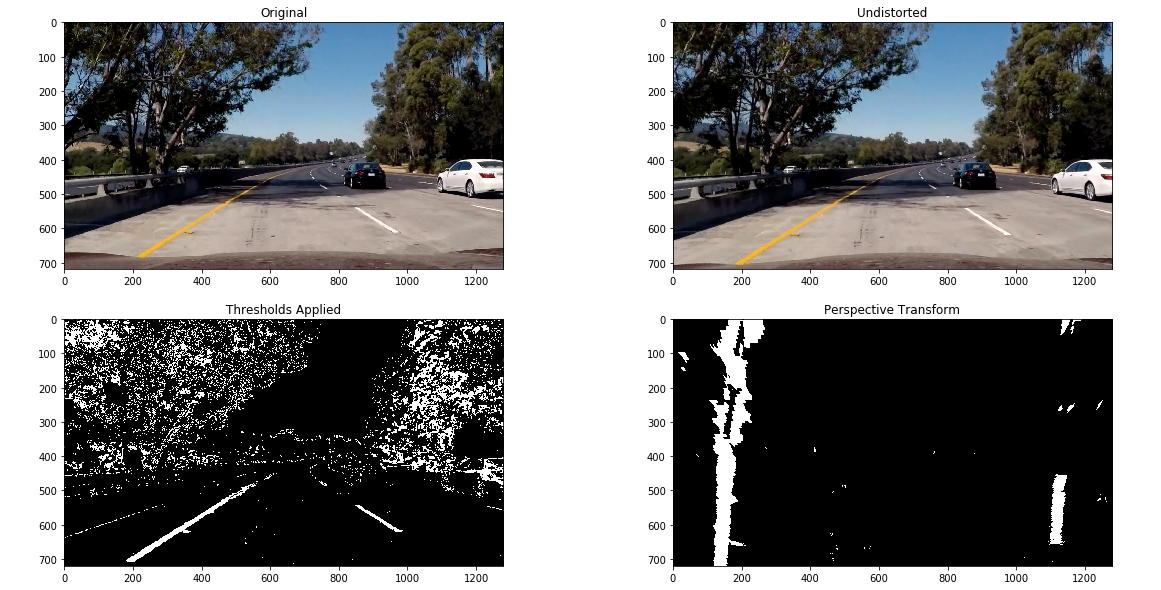

In [8]:
# Grab a sample image
image1 = CameraImage(mpimg.imread(os.path.join("test_images","test5.jpg")), cameraCal)
fig = plt.figure(figsize=(20,10))
plt.axis('off')

ax = fig.add_subplot(2,2,1)
ax.imshow(image1.img)
ax.set_title("Original")

# Undistort
image1.undistort_image()
mpimg.imsave(os.path.join("output_images","test5_undistorted.jpg"),image1.img)

ax = fig.add_subplot(2,2,2)
ax.imshow(image1.img)
ax.set_title("Undistorted")

# Apply gradient thresholds
image1.apply_thresholds()
mpimg.imsave(os.path.join("output_images","test5_gradient_thresholds.jpg"),image1.img,cmap='gray')

ax = fig.add_subplot(2,2,3)
ax.imshow(image1.img,cmap='gray')
ax.set_title("Thresholds Applied")

# Perspective transform
image1.perspective_transform()
mpimg.imsave(os.path.join("output_images","test5_perspective_warp.jpg"),image1.img,cmap='gray')

ax = fig.add_subplot(2,2,4)
ax.imshow(image1.img,cmap='gray')
ax.set_title("Perspective Transform")

### Lane Finding Helpers

Below are some helper functions to find lanes using various methods and plot the results.  These are mostly copy/modified from the course materials, but I updated them to account for running off the end of the image, and to avoid multiple lane direction changes in a single image

In [9]:
def find_lane_pixels(binary_warped, nwindows=12, margin=50,  minpix=50):
    """Use a historgram and sliding window to find lane pixels from 
    the bottom to the top of the image and return found lane pixels
    """
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    marked_lane_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint      

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height     
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin        
               
        # If we are running off the end of the image, exit
        if (win_xleft_low < 0) or (win_xright_high > binary_warped.shape[1]):
            break

        # Draw the windows on the visualization image
        cv2.rectangle(marked_lane_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(marked_lane_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 

        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, marked_lane_img


def search_around_poly(binary_warped, left_fit, right_fit, left_fitx, right_fitx, margin=50):
    """Search for lanes around an input polynomial and return found lane pixels in that boundary"""
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Set the area of search based on activated x-values 
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    marked_lane_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(marked_lane_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(marked_lane_img, np.int_([right_line_pts]), (0,255, 0))

    return leftx, lefty, rightx, righty, marked_lane_img 

Here I tried out the convolution + centroids method for lane finding to compare the results.  The functions are derived from the course materials but the data inside needed various modifications in order to return the same arrays as the sliding window approach in find_lane_pixels().

In [10]:
def window_mask(width, height, img_ref, center,level):
    """Apply a mask within a certain window"""
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_lane_pixels_convolution(image, window_width=50, window_height=60, margin=100, minpix=50):
    """Apply convolution to sliding window and find centroids and return found pixels within each window"""
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Identify the nonzero pixels in x and y within the window #
    win_y_low = image.shape[0] - window_height
    win_y_high = image.shape[0] 
    offset = window_width/2
    l_min_index = int(max(l_center-offset,0))
    l_max_index = int(min(l_center+offset,image.shape[1]))
    r_min_index = int(max(r_center-offset,0))
    r_max_index = int(min(r_center+offset,image.shape[1]))
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= l_min_index) &  (nonzerox < l_max_index)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= r_min_index) &  (nonzerox < r_max_index)).nonzero()[0]

    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)    
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2        
                
        # If we are running off the end of the image, exit
        if ((l_center-offset) < 0) or ((r_center+offset) > image.shape[1]):
            break
        
        l_min_index = int(max(l_center-offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        new_l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center-offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        new_r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
               
        win_y_low = image.shape[0] - (level+1)*window_height
        win_y_high = image.shape[0] - level*window_height  
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= (new_l_center-offset)) &  (nonzerox < (new_l_center+offset))).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= (new_r_center-offset)) &  (nonzerox < (new_r_center+offset))).nonzero()[0]
            
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            l_center = new_l_center
            left_lane_inds.append(good_left_inds)
        
        if len(good_right_inds) > minpix:        
            r_center = new_r_center 
            right_lane_inds.append(good_right_inds)
        
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))                
        
        
    # If we found any window centers
    if len(window_centroids) > 0:
        
        # Points used to draw all the left and right windows
        l_points = np.zeros_like(image)
        r_points = np.zeros_like(image)  

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,image,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,image,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage= np.dstack((image, image, image))*255 # making the original road pixels 3 color channels
        marked_lane_img = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
    
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty, marked_lane_img
 

This fits a 2nd order polynomial to the found lane pixels.  This was mostly taken from the course materials, but the actual plotting of the lines is now configurable. 

In [11]:
def fit_polynomial(binary_warped, leftx, lefty, rightx, righty, marked_lane_img, plot_lanes=False):
    """Fit a second order polynomial and plot the lines on an image"""
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    ## Visualization ##
    # Colors in the left and right lane regions
    marked_lane_img[lefty, leftx] = [255, 0, 0]
    marked_lane_img[righty, rightx] = [0, 0, 255]

    if plot_lanes:
        # Plots the left and right polynomials on the lane lines
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')

    return left_fitx, right_fitx, ploty, left_fit, right_fit, marked_lane_img

This combines the results of the above functions with the original image to give an output image with the lanes found

In [12]:
def combine_images(warped_image, leftx, lefty, rightx, righty, 
                   left_fitx, right_fitx, ploty, original_image, 
                   marked_lane_img, cameraCal,lanesFound=True):
    """Combine orginal image with found lane information 
    and draw filled polynomial onto lane.  Also, add small image 
    of the result of lane finding to top corner"""
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Only draw the lanes if the lanes have been found.  Will be important later for dropped frames...
    if lanesFound:
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Create a small marked lane image to place in the top corner
    marked_lane_img_small = np.zeros((int(marked_lane_img.shape[0]/4),int(marked_lane_img.shape[1]/4),marked_lane_img.shape[2]))
    marked_lane_img_small = cv2.resize(marked_lane_img, (int(marked_lane_img.shape[1]/4),int(marked_lane_img.shape[0]/4)))
    
    # Add lane points
    color_warp[lefty, leftx] = [255, 0, 0]
    color_warp[righty, rightx] = [0, 0, 255]

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cameraCal.warp_to_original_perspective(color_warp)
    # Combine the result with the original image
    result = cv2.addWeighted(original_image, 1, newwarp, 0.3, 0)
    
    # Add composite of marked lane image
    result[:marked_lane_img_small.shape[0],-marked_lane_img_small.shape[1]:,:] = marked_lane_img_small
    return result

### Test lane finding

Here I test out the two lane finding approaches on my transformed image

In [13]:
# Find pixels with histogram sliding window
leftx, lefty, rightx, righty, marked_lane_img = find_lane_pixels(image1.img)
left_fitx, right_fitx, ploty, left_fit, right_fit, marked_lane_img = fit_polynomial(image1.img, leftx, lefty, rightx, righty, marked_lane_img, plot_lanes=True )
mpimg.imsave(os.path.join("output_images","test5_found_lanes.jpg"),marked_lane_img)
plt.imshow(marked_lane_img)

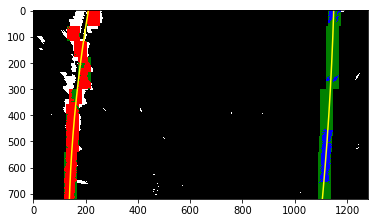

In [14]:
# Find pixels with convoluation method
leftxc, leftyc, rightxc, rightyc, marked_lane_imgc = find_lane_pixels_convolution(image1.img)
left_fitxc, right_fitxc, plotyc, left_fitc, right_fitc, marked_lane_imgc = fit_polynomial(image1.img, leftxc, leftyc, rightxc, rightyc, marked_lane_imgc, plot_lanes=True )
mpimg.imsave(os.path.join("output_images","test5_found_lanes_centoids.jpg"),marked_lane_imgc)
plt.imshow(marked_lane_imgc)

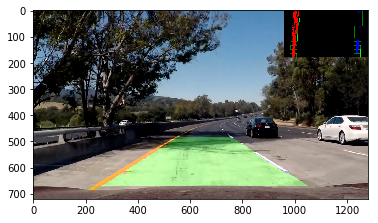

In [15]:
# Show the found results
result = combine_images(image1.img, leftx, lefty, rightx, righty, left_fitx, right_fitx, ploty, image1.originalImage, marked_lane_img, cameraCal)
plt.imshow(result)
mpimg.imsave(os.path.join("output_images","test5_final_result.jpg"),result)

### Test radius and distance calculations

Here I setup the radius and distance calculations, to use for reference later.  These calculations are in pixels.

In [16]:
y_eval = np.max(ploty)
left_curverad =    ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad =   ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

print("Left Curve Radius in Pixels: {0}".format(left_curverad))
print("Right Curve Radius in Pixels: {0}".format(right_curverad))

lane_size = right_fitx[0] - left_fitx[-1]
lane_center = lane_size/2 + left_fitx[-1]
dist_from_center_pixels = np.absolute(image1.originalImage.shape[1]/2 - lane_center)
print("Distance from lane center in Pixels: {0}".format(dist_from_center_pixels))

Left Curve Radius in Pixels: 246709.0491845686
Right Curve Radius in Pixels: 18373.383937287683
Distance from lane center in Pixels: 4.51926251746454


## Combined Pipeline

Combine all the previous steps into a processing pipe that can be used with the moviepy video processing.

In [17]:
# Global lane fit data
left_fit_g = None
right_fit_g = None
left_fitx_g = None
right_fitx_g = None
first_frame_g = True

def reset_fit():
    """Reset fit data"""
    global first_frame_g
    first_frame_g = True

def process_image(image):
    """Combine all previous steps into a single image processing pipe to be used to process videos"""    
    
    #Init Cam Image
    camImage = CameraImage(image, cameraCal)
    
    # Apply pipline
    camImage.apply_full_pipeline()
    
    #Global fits
    global left_fit_g
    global right_fit_g
    global left_fitx_g
    global right_fitx_g
    global first_frame_g
    
    # Find Lanes
    if first_frame_g:
        leftx, lefty, rightx, righty, marked_lane_img = find_lane_pixels(camImage.img)
        first_frame_g = False
    else:
        leftx, lefty, rightx, righty, marked_lane_img = search_around_poly(camImage.img, left_fit_g, 
                                                                           right_fit_g, left_fitx_g, right_fitx_g,)
    
    lane_dropped = (leftx.size == 0 or lefty.size == 0 or rightx.size ==0 or righty.size == 0)
    # Fit the found lane info into a polynomial if found
    if lane_dropped:
        #Frame dropped, cannot fit, reset the pipe
        reset_fit()
        ploty = np.linspace(0, camImage.img.shape[0]-1, camImage.img.shape[0] )
    else:
        left_fitx_g, right_fitx_g, ploty, left_fit_g, right_fit_g, marked_lane_img = fit_polynomial(camImage.img, leftx, lefty, rightx, righty, marked_lane_img)
    
    # Combine    
    result = combine_images(camImage.img, leftx, lefty, rightx, righty, left_fitx_g, right_fitx_g, ploty, camImage.originalImage, marked_lane_img, cameraCal)

    if not lane_dropped:
        # Calc distance from center 
        lane_size = right_fitx_g[-1] - left_fitx_g[0]
        lane_center = lane_size/2 + left_fitx_g[0]
        dist_from_center_pixels = np.absolute(image1.originalImage.shape[1]/2 - lane_center)           
        dist_from_center_meters = dist_from_center_pixels * cameraCal.xm_per_pix        

        #Calc Curve radius in Meters:  
        left_fit_m = np.polyfit(lefty*cameraCal.ym_per_pix, leftx*cameraCal.xm_per_pix, 2)
        right_fit_m = np.polyfit(righty*cameraCal.ym_per_pix, rightx*cameraCal.xm_per_pix, 2)
        y_eval = np.max(ploty)
        left_radius_meters = ((1 + (2*left_fit_m[0]*y_eval*cameraCal.ym_per_pix + left_fit_m[1])**2)**1.5) / np.absolute(2*left_fit_m[0])
        right_radius_meters = ((1 + (2*right_fit_m[0]*y_eval*cameraCal.ym_per_pix + right_fit_m[1])**2)**1.5) / np.absolute(2*right_fit_m[0])

        # Add some text to the screen to print radious and distance information
        cv2.putText(result,"Left radius: %6.4fm" % left_radius_meters, (10,50), cv2.FONT_HERSHEY_SIMPLEX, 1 ,(255,255,255), 2)
        cv2.putText(result,"Right radius: %6.4fm" % right_radius_meters, (10,100), cv2.FONT_HERSHEY_SIMPLEX, 1 ,(255,255,255), 2)
        cv2.putText(result,"Dist from Center: %3.4fm" % dist_from_center_meters, (10,150), cv2.FONT_HERSHEY_SIMPLEX, 1 ,(255,255,255), 2)

    else: 
        cv2.putText(result,"Failed to find lane! Reset triggered...", (10,50), cv2.FONT_HERSHEY_SIMPLEX, 1 ,(255,255,255), 2)
        
    return result


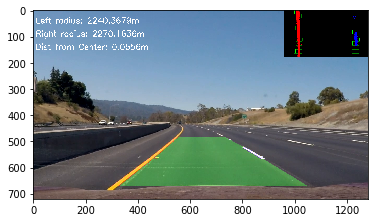

In [18]:
# Test the pipeline on a single frame of the project video to verify it works all together
clip = VideoFileClip("project_video.mp4")
plt.imshow(process_image(clip.get_frame(4)))
clip.reader.close()
clip.audio.reader.close_proc()

### Test pipeline on project video

Apply the above pipeline to the project video.

In [19]:
# Make sure global variables are reset 
reset_fit()

# Process the project video using the pipeline
output = 'project_video_out.mp4'
clip1 = VideoFileClip("project_video.mp4")
proc_clip = clip1.fl_image(process_image) 
%time proc_clip.write_videofile(output, audio=False)

# Close the video to avoid open handles
clip1.reader.close()
clip1.audio.reader.close_proc()

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [05:27<00:00,  3.85it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

Wall time: 5min 28s


In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

Things are working pretty well, but it loses the lane near the end.

### Test pipeline on challenge video

Try out the pipeline on the challenge video.

In [21]:
# Make sure global variables are reset 
reset_fit()

# Process the project video using the pipeline
output2 = 'challenge_video_out.mp4'
clip2 = VideoFileClip("challenge_video.mp4")
proc_clip2 = clip2.fl_image(process_image) 
%time proc_clip2.write_videofile(output2, audio=False)

# Close the video to avoid open handles
clip2.reader.close()
clip2.audio.reader.close_proc()

[MoviePy] >>>> Building video challenge_video_out.mp4
[MoviePy] Writing video challenge_video_out.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [01:59<00:00,  4.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_out.mp4 

Wall time: 2min


In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output2))

The lane finding seems to be following the wrong lines for the most part with the road imperfections.

## Tuning the pipeline

Investigate what the pipeline sees in one of the more complex portions of the challenge video to tune the thresholding.

In [23]:
challengeclip = VideoFileClip("challenge_video.mp4")

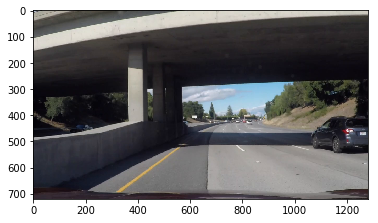

In [24]:
challengeImage = CameraImage(challengeclip.get_frame(4), cameraCal)
plt.imshow(challengeImage.img)

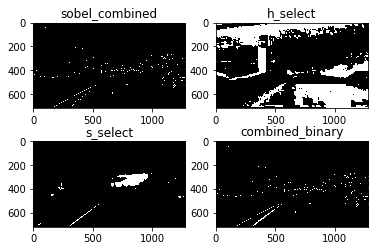

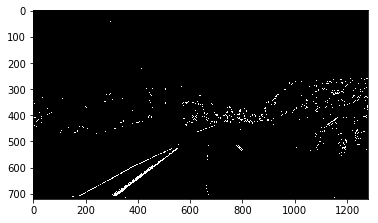

In [25]:
challengeImage.undistort_image()
challengeImage.apply_thresholds(plot=True)
plt.imshow(challengeImage.img, cmap="gray")

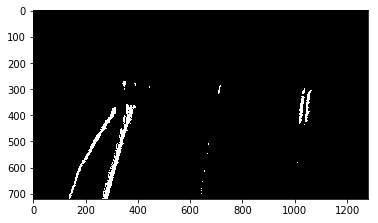

In [26]:
challengeImage.perspective_transform()
plt.imshow(challengeImage.img,cmap='gray') 

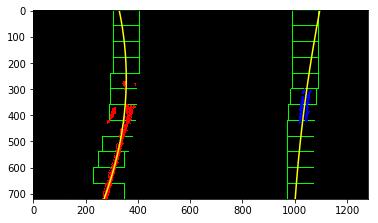

In [27]:
leftx2, lefty2, rightx2, righty2, marked_lane_img2 = find_lane_pixels(challengeImage.img)
left_fit2, right_fitx2, ploty2, left_fit2, right_fit2, marked_lane_img2 = fit_polynomial(challengeImage.img, leftx2, lefty2, rightx2, righty2, marked_lane_img2, plot_lanes=True )
plt.imshow(marked_lane_img2)

Try the improved thresholding, with additional white/yellow selection, and a hue filter applied to the sobel gradient.

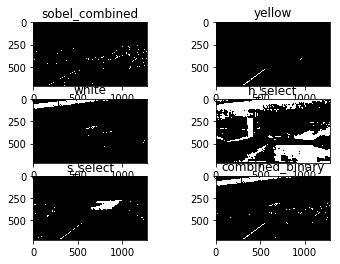

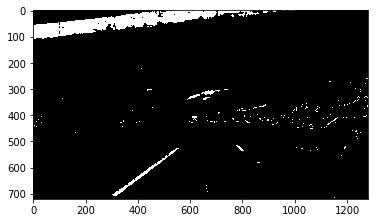

In [28]:
challengeImage = CameraImage(challengeclip.get_frame(4), cameraCal, improvedThreshIn=True)
challengeImage.undistort_image()
challengeImage.apply_thresholds(plot=True)
plt.imshow(challengeImage.img, cmap="gray")

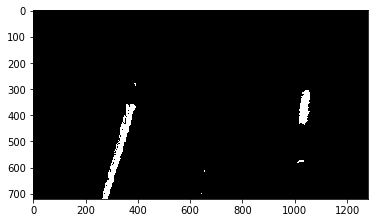

In [29]:
challengeImage.perspective_transform()
plt.imshow(challengeImage.img,cmap='gray') 

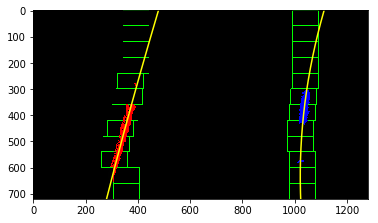

In [30]:
leftx2, lefty2, rightx2, righty2, marked_lane_img2 = find_lane_pixels(challengeImage.img)
left_fit2, right_fitx2, ploty2, left_fit2, right_fit2, marked_lane_img2 = fit_polynomial(challengeImage.img, leftx2, lefty2, rightx2, righty2, marked_lane_img2, plot_lanes=True )
plt.imshow(marked_lane_img2)

## Line Helper Class

To improve upon the processing pipeline, I used the suggestion from the course materials to create a "LaneLine" class to store the history of previously detected lines, calculate an average fit, and also do some sanity checking on each detect to throw away dangerous outliers.  I also setup a cleaner reset method if the lanes were lost over a certain number of frames. 

In [31]:
class LaneLine():
    """A class that contains the characteristics of each line detection.

    Attributes:
        cameraCal (CameraCalibration):  Camera calibration data
        
        size_of_history (int): amount of historical fits to store
        min_detections (int): minimum number of accepted fits before lane can be considered detected
        dropped_frames_threshold (int): Maximum amount of dropped frames before lane state is reset
        radius_thresholds (array): min and max thresholds for radius in meters 
        lane_pos_threshold (float): maximum threshold for distance from lane center
        coefficient_threshold_score (float): maximum outlier score theshold 
        
        detected (bool): Was the line detected in the last iteration?
        dropped_frames (int): Amount of subsequent frame drops
        recent_xfitted (queue): x values of the last "size_of_history" fits of the line
        recent_fitted (queue): polynomial coefficient of the last "size_of_history" fits of the line
        bestx (int): average x values of the fitted line over the last "size_of_history" iterations
        best_fit (int): polynomial coefficients averaged over the last "size_of_history" iterations
        current_fit (int): polynomial coefficients for the most recent fit
        current_fitx (int): x values for the most recent fit
        radius_of_curvature (int): radius of curvature of the line in some units
        line_base_pos (int): distance in meters of vehicle center from the line
        diffs (array): difference in fit coefficients between last and new fits
        allx (array): x values for detected line pixels
        ally (array): y values for detected line pixels
    """
    def __init__(self,cameraCalIn): 
        
        # Input calibration
        self.cameraCal = cameraCalIn
        
        # Hyper params
        self.size_of_history = 5
        self.min_detections = 5
        self.dropped_frames_threshold = 10
        self.radius_thresholds = [100,100000]
        self.lane_pos_threshold = 3.0
        self.coefficient_threshold_score = 1.0
        
        # Lane detection state information
        self.detected = False 
        self.dropped_frames = 0
        self.recent_xfitted = queue.Queue(maxsize=self.size_of_history)
        self.recent_fitted = queue.Queue(maxsize=self.size_of_history)
        self.bestx = None       
        self.best_fit = None
        self.current_fit = [np.array([False])] 
        self.current_fitx = None
        self.radius_of_curvature = 0 
        self.line_base_pos = 0 
        self.diffs = np.array([0,0,0], dtype='float') 
        self.allx = None  
        self.ally = None         
        
        
    def add_new_lines(self, x,y,image_height=720, image_width=1280):
        """Add new lane line data into the pipeline"""
        self.allx = x
        self.ally = y
        
        # Drop frame if no lane pixels are detected
        if (x.size == 0 or y.size == 0):
            self.dropped_frames += 1
            self.check_drop_limit()
            return            
        
        # Fit a second order polynomial to each using `np.polyfit`
        self.current_fit = np.polyfit(y, x, 2)
        
        # Generate x and y values for plotting
        ploty = np.linspace(0, image_height-1, image_height )
        try:
            self.current_fitx = self.current_fit[0]*ploty**2 + self.current_fit[1]*ploty + self.current_fit[2]
        except TypeError:
            # Drop frame if fit fails
            print('The function failed to fit a line!')
            self.dropped_frames += 1
            self.check_drop_limit()
            return 
        
        #Calc fit difference
        if self.detected:
            self.diffs = self.best_fit - self.current_fit
        
        # Calculate fit in Meters
        fit_m = np.polyfit(self.ally*self.cameraCal.ym_per_pix, self.allx*self.cameraCal.xm_per_pix, 2)  
        
        # Calc radius in meters
        self.radius_of_curvature = ((1 + (2*fit_m[0]*image_height*self.cameraCal.ym_per_pix + fit_m[1])**2)**1.5) / np.absolute(2*fit_m[0])
        
        # Calc lane distatnce from center.  
        
        #First need to extrapolate lowest x point.
        line_base_x = fit_m[0]*((image_height*self.cameraCal.ym_per_pix)**2) + fit_m[1]*(image_height*self.cameraCal.ym_per_pix) + fit_m[2]
        
        # Then subtract from center
        self.line_base_pos = np.absolute(image_width*self.cameraCal.xm_per_pix/2 - line_base_x)
        
        # Update fit averages and throw up bad data
        self.update_best_fit()
        
        # Verify we haven't exceeded the drop limit
        self.check_drop_limit()
        
        
    def reset_state(self):
        """Reset lane state"""
        self.detected = False
        self.droppedFrames = 0
        self.recent_xfitted = queue.Queue(maxsize=self.size_of_history)
        self.recent_fitted = queue.Queue(maxsize=self.size_of_history)
        self.bestx = None       
        self.best_fit = None
        
    
    def update_best_fit(self): 
        """Updates lane state with new input data"""
        ## Validate vals if we have a line to check against          
        if ((self.line_base_pos > self.lane_pos_threshold) or 
            (self.radius_of_curvature < self.radius_thresholds[0]) or 
            (self.radius_of_curvature > self.radius_thresholds[1])):
            self.dropped_frames += 1
            return
        
        
        if self.detected:
            # Calculate outlier score based on Median Absoulte Deviation
            # See https://en.wikipedia.org/wiki/Median_absolute_deviation
            coeff = np.array(list(self.recent_fitted.queue))
            median = np.median(coeff, axis=0)
            diff = np.absolute(coeff - median)
            med_abs_deviation = np.median(diff, axis=0)   
            score = 0.6745 * self.diffs / med_abs_deviation
            if (score.any() > self.coefficient_threshold_score):
                self.dropped_frames += 1
                return
        
        # If we got to this point, we are going to keep the frame.
        self.dropped_frames = 0
        
        # Make sure we don't overflow
        if self.recent_xfitted.full():
            self.recent_xfitted.get()
            self.recent_fitted.get()                     
            
        # Add data to queues
        self.recent_xfitted.put(self.current_fitx)        
        self.recent_fitted.put(self.current_fit) 
        
        # Check if we've reached a detection min
        if self.recent_xfitted.qsize() >= self.min_detections:
            self.detected = True

        # Caclulate average
        if self.recent_xfitted.qsize() == 1:
            self.bestx = self.current_fitx
            self.best_fit = self.current_fit        
        else:        
            self.bestx = np.average(np.array(list(self.recent_xfitted.queue)),axis=0)
            self.best_fit = np.average(np.array(list(self.recent_fitted.queue)),axis=0)           

    def check_drop_limit(self):  
        """Check for a dropped frames limit, and reset if necessary"""
        if self.dropped_frames >= self.dropped_frames_threshold:
            self.reset_state()
    

## Improved Pipeline

The code below is a modified version of the image processing pipeline that utlizes the new LaneLine class and its methods.

In [32]:
# global lane lines
leftLane = LaneLine(cameraCal)
rightLane = LaneLine(cameraCal)

def resetLanes():
    """Reset lane lines"""
    global leftLane
    global rightLane
    
    leftLane = LaneLine(cameraCal)
    rightLane = LaneLine(cameraCal)

def process_image_improved(image):
    """Apply improved image pipeline using the new LaneLine class and its capabilities"""
    
    #Init Cam Image, and make sure improved thresholds are used
    camImage = CameraImage(image, cameraCal, improvedThreshIn=True)
    
    # Apply image pipline
    camImage.apply_full_pipeline()
    
    global leftLane
    global rightLane

    lanes_found = leftLane.detected and rightLane.detected
    # Find Lanes
    if not lanes_found:
        leftx, lefty, rightx, righty, marked_lane_img = find_lane_pixels(camImage.img)
    else:
        leftx, lefty, rightx, righty, marked_lane_img = search_around_poly(camImage.img, 
                                                                           leftLane.best_fit, rightLane.best_fit, 
                                                                           leftLane.bestx, rightLane.bestx)
        
    # Add Lines
    leftLane.add_new_lines(leftx, lefty)
    rightLane.add_new_lines(rightx,righty)  
    
    # Update Lanes found
    lanes_found = leftLane.detected and rightLane.detected
    
    ## Visualization ##
    # Colors in the left and right lane regions
    marked_lane_img[lefty, leftx] = [255, 0, 0]
    marked_lane_img[righty, rightx] = [0, 0, 255]
    ploty = np.linspace(0, camImage.img.shape[0]-1, camImage.img.shape[0] )
        
    
    # Combine
    result = combine_images(camImage.img, leftx, lefty, rightx, righty, 
                            leftLane.bestx, rightLane.bestx, 
                            ploty, camImage.originalImage, marked_lane_img, cameraCal, lanesFound=lanes_found)
     
    
    dist_from_center_meters = np.absolute(rightLane.line_base_pos - leftLane.line_base_pos)   

    # Apply text to screen with useful information
    if lanes_found:
        cv2.putText(result,"Left radius: %6.4fm" % leftLane.radius_of_curvature, (10,50), cv2.FONT_HERSHEY_SIMPLEX, 1 ,(255,255,255), 2)
        cv2.putText(result,"Right radius: %6.4fm" % rightLane.radius_of_curvature, (10,100), cv2.FONT_HERSHEY_SIMPLEX, 1 ,(255,255,255), 2)
        cv2.putText(result,"Dist from Center: %3.4fm" % dist_from_center_meters, (10,150), cv2.FONT_HERSHEY_SIMPLEX, 1 ,(255,255,255), 2)
        cv2.putText(result,"Dropped frames: L:%d, R:%d" % (leftLane.dropped_frames, rightLane.dropped_frames), (10,200), cv2.FONT_HERSHEY_SIMPLEX, 1 ,(255,255,255), 2)
    
    else:
        cv2.putText(result,"Searching for lanes...", (10,50), cv2.FONT_HERSHEY_SIMPLEX, 1 ,(255,255,255), 2)

    return result


## Apply improved pipeline to videos

Apply the new improved pipeline to the original video first to see how it compares

In [33]:
# Reset lane information
resetLanes()

# Apply improved pipeline to original video
output3 = 'project_video_out_improved.mp4'
clip3 = VideoFileClip("project_video.mp4")
proc_clip3 = clip3.fl_image(process_image_improved)
%time proc_clip3.write_videofile(output3, audio=False)
clip3.reader.close()
clip3.audio.reader.close_proc()

[MoviePy] >>>> Building video project_video_out_improved.mp4
[MoviePy] Writing video project_video_out_improved.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [05:37<00:00,  3.73it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out_improved.mp4 

Wall time: 5min 38s


In [34]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output3))

Apply improved pipeline to challenge video

In [35]:
resetLanes()
output4 = 'challenge_video_out_improved.mp4'
clip4 = VideoFileClip("challenge_video.mp4")
proc_clip4 = clip4.fl_image(process_image_improved)
%time proc_clip4.write_videofile(output4, audio=False)
clip4.reader.close()
clip4.audio.reader.close_proc()

[MoviePy] >>>> Building video challenge_video_out_improved.mp4
[MoviePy] Writing video challenge_video_out_improved.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [02:06<00:00,  3.84it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_out_improved.mp4 

Wall time: 2min 6s


In [36]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output4))

## Harder Challenge Video

Try out the even harder challenge video to see how the pipeline fares.

In [37]:
resetLanes()
output5 = 'harder_challenge_video_out.mp4'
clip5 = VideoFileClip("harder_challenge_video.mp4")
proc_clip5 = clip5.fl_image(process_image_improved)
%time proc_clip5.write_videofile(output5, audio=False)
clip5.reader.close()
clip5.audio.reader.close_proc()

[MoviePy] >>>> Building video harder_challenge_video_out.mp4
[MoviePy] Writing video harder_challenge_video_out.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1199/1200 [05:51<00:00,  3.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_out.mp4 

Wall time: 5min 52s


In [38]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output5))

Not a great result, but seems mostly due to the fact that thresholding pipeline cannot detect lanes well in varied lighting.  Would need to find a way to tune the pipeline for this scneario to make signficant additional progress.  Also might need to expand view window for tighter curves, and find ways to avoid lane detections from overlapping.  